## Original Problem Statement From Milestone 1
The problem that we want to explore is to analyze whether or not it is possible to build a machine learning model to predict the median salary of a student given institution location (state) and field of study.

An increasing number of young students across the years are uncertain in the career paths they enrolled as evident from a survey done by CampusTechnology in which 68% of Gen Z students, 63% of Millennial students and 49% of Gen X students express worry in their career path choices. Moreover, close to 80% of students mentioned that an online tool for choosing majors would be extremely helpful. The increasing number of young students placing greater value in their enrollment choice and being stressed about it has lead us to derive a machine learning model to provide an easy and insightful solution for this. 

For example, John has a set of states that he prefers so that it is not too far away from his hometown/family. Also, he has passion in Computer Science and Art. His family suggests that he choose a major which yields a better career. John's family translates “better career” to salary. So, John can use our machine learning model to get the salary estimation. John can try several combinations of states and majors in order to decide his final decision.

We are planning to build a machine learning model using multiple linear regression, for each combination of states and majors. The candidate features that we initially think have a linear correlation with the dependent variable are SAT or ACT score (SAT_AVG), admission rate (ADM_RATE), tuition fee (TUITIONFEE_IN/OUT), and average faculty staff salary (AVGFASCAL). We might also consider other features, such as retention rate, completion rate, family income, and financial aid later on.

In the process, we are going to apply linear regression recipes that have been taught in the lecture and we will provide qualitative/quantitative explanations on why the model works or does not work. The (tentative) dataset that we will be using is the combination of several files and we will do preprocessing and data cleansing towards features that support our model. Additionally, we might also consider to use techniques other than linear regression as we learn more in the upcoming lectures.

Reference: Dian Schaffhauser, 'Survey: Most Students Find Choosing a Major Stressful', CampusTechnology, 24 October 2019. Available: https://campustechnology.com/articles/2019/10/24/survey-most-students-find-choosing-a-major-stressful.aspx?s=ct_le_301019

## Altered Problem Statement
We would like to alter the original problem statement to a more generalized version of it. For this project, we would like to build an salary estimator model based on the school background. The reason for this is because it is not possible for us to track the contribution of each field of study towards the target variable.  
We will first build the estimator using **OLS (Ordinary Least Squares)**, followed by **RFR (Random Forest Regressor)** and finally using **NN (Neural Network)**. We want to see which models give the best accuracy and we will try to reason why is it the case.

## Creating a Linear Regression Model

### Loading Dataset
We select dataset `MERGED2013_14_PP`, `MERGED2014_15_PP`, `MERGED2018_19_PP` because it contains the least missing data for building the model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
!pip install torchmetrics
from torchmetrics.functional import r2_score as torch_r2_score

C:\Users\tioqy\anaconda3\envs\ssdfsdfsdfsdfsdf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme()
plt.style.use('seaborn')

df_1 = pd.read_csv("MERGED2013_14_PP.csv")
df_2 = pd.read_csv("MERGED2014_15_PP.csv")
df_3 = pd.read_csv("MERGED2018_19_PP.csv")
df = df_1.append(df_2)
df = df.append(df_3)

C:\Users\tioqy\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3258: DtypeWarning: Columns (1547,1575,1576,1577,1587,1588,1729,1909,1910,1911,1912,1913) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\tioqy\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3258: DtypeWarning: Columns (1537,1540,1542,1575,1589,1606,1610,1614,1615,1729,1909,1910,1911,1912,1913) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\tioqy\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3258: DtypeWarning: Columns (1729,1909,1910,1911,1912,1913,2376,2377,2958) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Dependent Variable:**  
- `MD_EARN_WNE_P10`

**Independent Variables:**  
`['SAT_AVG', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'AVGFACSAL', 'ADM_RATE', 
  'NUMBRANCH', 'TUITFTE', 'INEXPFTE', 'PRGMOFR', 'COSTT4_A', 'COSTT4_P', 'UGDS', 
  'UGDS_MEN', 'UGDS_WOMEN', 'PFTFAC', 'PCTPELL', 'FTFTPCTFLOAN', 'FTFTPCTPELL', 
  'DEBT_MDN', 'RET_FT4', 'C200_L4', 'LO_INC_COMP_ORIG_YR2_RT', 'HI_INC_COMP_ORIG_YR2_RT',
  'MD_FAMINC', 'WDRAW_DEBT_MDN', 'ACTCMMID', 'DEP_STAT_PCT_IND']`


### Recipe of the regression
#### 1. Keep aside 20% of data for the model validation purpose

In [3]:
TARGET_VARIABLE = 'MD_EARN_WNE_P10'

def cleanNumericFeature(df, columns):
    for column in columns:
        df[column] = df[column].replace('PrivacySuppressed', np.nan)
        df[column] = df[column].astype('float')
    return df

num_features = ['SAT_AVG', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'AVGFACSAL', 'ADM_RATE', 
        'NUMBRANCH', 'TUITFTE', 'INEXPFTE', 'PRGMOFR', 'COSTT4_A', 'COSTT4_P', 'UGDS', 
        'UGDS_MEN', 'UGDS_WOMEN', 'PFTFAC', 'PCTPELL', 'FTFTPCTFLOAN', 'FTFTPCTPELL', 
        'DEBT_MDN', 'RET_FT4', 'C200_L4', 'LO_INC_COMP_ORIG_YR2_RT', 'HI_INC_COMP_ORIG_YR2_RT',
        'MD_FAMINC', 'WDRAW_DEBT_MDN', 'ACTCMMID', 'DEP_STAT_PCT_IND']

# df.dropna(subset=num_features, inplace=True)
df = cleanNumericFeature(df, num_features + [TARGET_VARIABLE])
df = df.dropna(subset=[TARGET_VARIABLE])
df = df.reset_index(drop=True)

cat_feature = ['CONTROL']
X = df[num_features + cat_feature]
y = df[[TARGET_VARIABLE]]

We will split the dataset to test and train before preprocessing.

#### 2. Obtain summary statistics of various features


Check statistics for numerical variables:

In [6]:
display(X.describe())
display(y.describe())

,SAT_AVG,TUITIONFEE_IN,TUITIONFEE_OUT,AVGFACSAL,ADM_RATE,NUMBRANCH,TUITFTE,INEXPFTE,PRGMOFR,COSTT4_A,...,DEBT_MDN,RET_FT4,C200_L4,LO_INC_COMP_ORIG_YR2_RT,HI_INC_COMP_ORIG_YR2_RT,MD_FAMINC,WDRAW_DEBT_MDN,ACTCMMID,DEP_STAT_PCT_IND,CONTROL
count,3956.000000,11823.000000,11176.000000,11666.000000,5877.000000,17609.000000,16404.000000,16404.000000,4926.000000,10816.000000,...,16327.000000,6222.000000,8344.000000,14067.000000,9187.000000,12175.000000,15617.000000,3814.000000,11924.000000,17609.000000
mean,1083.732811,14692.337985,17673.088583,6431.650266,0.682115,8.046851,10289.480127,7384.521641,5.845717,25564.862888,...,11007.549090,0.705634,0.543549,0.309317,0.307228,26354.840657,6361.724211,23.264027,0.529527,2.089045
std,135.435249,11813.123651,11009.496792,2332.610825,0.205892,22.568079,9726.147475,9723.366534,7.366583,13738.992795,...,5224.634841,0.185789,0.236906,0.222939,0.241114,19205.005795,2534.813635,3.540227,0.239771,0.858331
min,666.000000,0.000000,80.000000,173.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3990.000000,...,800.000000,0.000000,0.000000,0.004671,0.016484,0.000000,745.000000,2.000000,0.009119,1.000000
25%,997.000000,5173.000000,9299.250000,4879.250000,0.559200,1.000000,4405.750000,3746.000000,2.000000,14139.000000,...,7000.000000,0.624425,0.332100,0.124272,0.114195,14046.000000,4750.000000,21.000000,0.349176,1.000000
50%,1068.000000,12315.000000,15140.000000,6163.500000,0.701100,1.000000,9153.000000,5727.500000,4.000000,23108.000000,...,9500.000000,0.734800,0.572700,0.228612,0.210526,18900.000000,5500.000000,23.000000,0.584587,2.000000
75%,1152.000000,18519.000000,23091.000000,7699.750000,0.833500,4.000000,13873.250000,8401.250000,7.000000,32169.000000,...,14084.000000,0.824900,0.735300,0.505683,0.434783,32217.000000,7792.500000,25.000000,0.716690,3.000000
max,1566.000000,59430.000000,59430.000000,25143.000000,1.000000,143.000000,455440.000000,520552.000000,108.000000,75735.000000,...,38885.000000,1.000000,1.000000,0.954167,0.910714,120000.000000,30125.000000,36.000000,0.979251,3.000000


,MD_EARN_WNE_P10
count,17609.000000
mean,35384.509739
std,15288.441283
min,9100.000000
25%,25300.000000
50%,33145.000000
75%,42400.000000
max,250000.000000


Percentage of missing data for each feature:

In [7]:
percent_missing = X.isnull().sum() * 100 / len(X)
display(percent_missing.to_frame(name="Missing Values (%)"))

,Missing Values (%)
SAT_AVG,77.534215
TUITIONFEE_IN,32.858198
TUITIONFEE_OUT,36.532455
AVGFACSAL,33.749787
ADM_RATE,66.625021
NUMBRANCH,0.000000
TUITFTE,6.843092
INEXPFTE,6.843092
PRGMOFR,72.025669
COSTT4_A,38.576864


Correlation between numerical independent variables and target variable:

In [8]:
df[num_features + [TARGET_VARIABLE]].corr()[TARGET_VARIABLE].to_frame(name="correlation")

,correlation
SAT_AVG,0.687681
TUITIONFEE_IN,0.521261
TUITIONFEE_OUT,0.635781
AVGFACSAL,0.634033
ADM_RATE,-0.282674
NUMBRANCH,0.020981
TUITFTE,0.327339
INEXPFTE,0.435057
PRGMOFR,0.139812
COSTT4_A,0.566183


**Insight:**  
We need to scale the numerical values before fitting our model to prevent one variable dominates the estimators.

We have a categorical variable that needs to be converted to numerical value in order to be meaningful.

#### 3. Obtain scatterplots and correlation among various features

Here, we plot each of the numerical independent variables with the target variable to observe the trend:

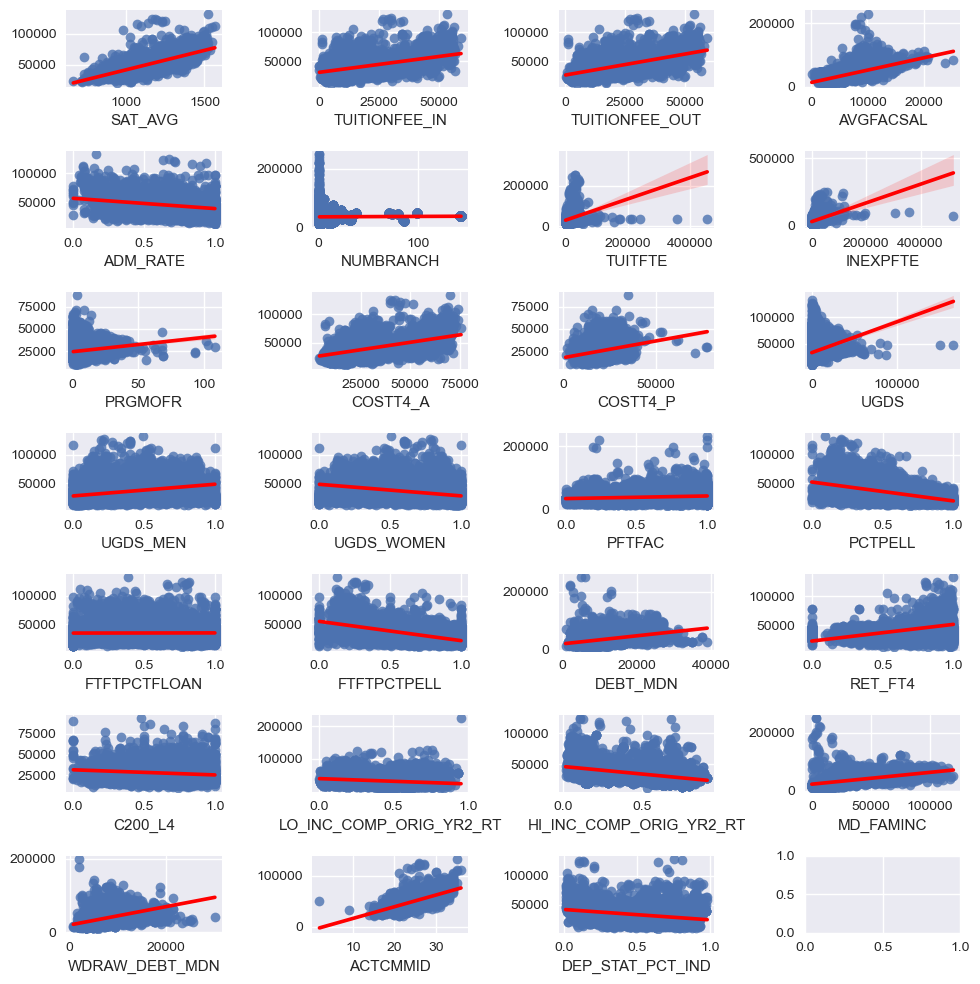

In [9]:
fig, (axes) = plt.subplots(7, 4, figsize=(10, 10))
k = 0
for i in range(7):
    if k == len(num_features): break
    for j in range(4):
        sns.regplot(ax=axes[i][j], x=X[num_features[k]], y=y[TARGET_VARIABLE], line_kws={"color": "red"})
        k += 1
        axes[i][j].yaxis.set_label_text('')
        if k == len(num_features): break
fig.yticklabels = False
fig.tight_layout()

**Insight:**  
Some variables have relation and some don't have relation with the target variable.  
We will eliminate some features after performing the first prediction.

#### 4. Check for the categorical variable and convert them to dummy variables

In [4]:
oh_enc = OneHotEncoder(categories='auto', handle_unknown='ignore')

control_enc = oh_enc.fit_transform(X[['CONTROL']])
control_enc_df = pd.DataFrame(control_enc.toarray(), columns=oh_enc.get_feature_names_out())
X = pd.concat([X, control_enc_df], axis=1)
X = X.drop(columns=['CONTROL'])

display(X.shape)
X

(17609, 30)

,SAT_AVG,TUITIONFEE_IN,TUITIONFEE_OUT,AVGFACSAL,ADM_RATE,NUMBRANCH,TUITFTE,INEXPFTE,PRGMOFR,COSTT4_A,...,C200_L4,LO_INC_COMP_ORIG_YR2_RT,HI_INC_COMP_ORIG_YR2_RT,MD_FAMINC,WDRAW_DEBT_MDN,ACTCMMID,DEP_STAT_PCT_IND,CONTROL_1,CONTROL_2,CONTROL_3
0,823.0,7182.0,12774.0,7079.0,0.8989,1.0,9063.0,7459.0,NaN,18888.0,...,NaN,0.030429,NaN,21286.0,9500.0,17.0,0.129875,1.0,0.0,0.0
1,1146.0,7206.0,16398.0,10170.0,0.8673,1.0,9033.0,17208.0,NaN,19990.0,...,NaN,0.161777,0.130217,35162.5,8250.0,25.0,0.319232,1.0,0.0,0.0
2,NaN,6870.0,6870.0,3849.0,NaN,1.0,12057.0,5123.0,NaN,12300.0,...,NaN,NaN,NaN,16618.5,6032.0,NaN,0.913953,0.0,1.0,0.0
3,1180.0,9192.0,21506.0,9341.0,0.8062,1.0,8322.0,9352.0,NaN,20306.0,...,NaN,0.157618,0.131488,33787.0,7500.0,26.0,0.389696,1.0,0.0,0.0
4,830.0,8720.0,15656.0,6557.0,0.5125,1.0,7813.0,7393.0,NaN,17400.0,...,NaN,0.029412,NaN,20269.0,9500.0,17.0,0.159023,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17604,NaN,6120.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,...,NaN,0.121025,0.197368,NaN,4940.0,NaN,NaN,1.0,0.0,0.0
17605,NaN,6120.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,...,NaN,0.121025,0.197368,NaN,4940.0,NaN,NaN,1.0,0.0,0.0
17606,NaN,6120.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,...,NaN,0.121025,0.197368,NaN,4940.0,NaN,NaN,1.0,0.0,0.0
17607,NaN,6120.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,...,NaN,0.121025,0.197368,NaN,4940.0,NaN,NaN,1.0,0.0,0.0


In [11]:
testt = X[['CONTROL_1',	'CONTROL_2', 'CONTROL_3']]
testt[TARGET_VARIABLE] = y[TARGET_VARIABLE]

C:\Users\flame\AppData\Local\Temp\ipykernel_37840\3300485824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testt[TARGET_VARIABLE] = y[TARGET_VARIABLE]


In [12]:
testt.corr()[TARGET_VARIABLE].to_frame(name="correlation")

,correlation
CONTROL_1,0.080240
CONTROL_2,0.359701
CONTROL_3,-0.394540
MD_EARN_WNE_P10,1.000000


#### 5. Performs appropriate feature selection and data preprocessing

In [13]:
display(X.shape)
display(y.shape)

(17609, 30)

(17609, 1)

In [5]:
pipeline = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                           ('scaler', StandardScaler())
                          ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = pd.DataFrame(pipeline.fit_transform(X_train), columns=X.columns.to_list())
X_train_transformed = sm.add_constant(X_train_transformed)

X_test_transformed = pd.DataFrame(pipeline.transform(X_test), columns=X.columns.to_list())
X_test_transformed = sm.add_constant(X_test_transformed)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

We will first use all features and then attempt to improve the model.

#### 6. Run linear regression. Check R<sup>2</sup>, MSE, Residual Plot, Q-Q Plot

In [16]:
# LR without Log(Responding Variable)
est = sm.OLS(y_train, X_train_transformed).fit()
print("LR without Log(Responding Variable):")
display(est.summary())

y_pred = est.predict(X_test_transformed)
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

LR without Log(Responding Variable):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     560.0
Date:                Tue, 11 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:55:11   Log-Likelihood:            -1.5038e+05
No. Observations:               14087   AIC:                         3.008e+05
Df Residuals:                   14057   BIC:                         3.010e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3.542e+04     88.288    401.134      0.000    3.52e+04    3.56e+04
SAT_AVG                  1612.6022    246.487      6.542      0.000    1129.455    2095.749
TUITIONFEE_IN              64.2612    419.477      0.153      0.878    -757.969     886.491
TUITIONFEE_OUT           -938.2526    309.958     -3.027      0.002   -1545.811    -330.694
AVGFACSAL                3587.8617    129.707     27.661      0.000    3333.619    3842.105
ADM_RATE                 -136.6823     96.754     -1.413      0.158    -326.332      52.968
NUMBRANCH                1325.4722    107.466     12.334      0.000    1114.825    1536.119
TUITFTE                  1663.5023    111.100     14.973      0.000    1445.731    1881.274
INEXPFTE                 2691.9128    103.409     26.032      0.000    2489.218    2894.607
PRGMOFR                   -85.8675     97.312     -0.882      0.378    -276.613     104.878
COSTT4_A                 -327.6569    341.743     -0.959      0.338    -997.518     342.204
COSTT4_P                 1050.3383     96.249     10.913      0.000     861.677    1239.000
UGDS                      674.3605    110.184      6.120      0.000     458.386     890.335
UGDS_MEN                 2323.5354    661.445      3.513      0.000    1027.016    3620.055
UGDS_WOMEN                430.1464    660.252      0.651      0.515    -864.035    1724.327
PFTFAC                   -237.0390     97.619     -2.428      0.015    -428.386     -45.692
PCTPELL                 -1698.9032    158.806    -10.698      0.000   -2010.184   -1387.623
FTFTPCTFLOAN             2155.7537    124.140     17.366      0.000    1912.424    2399.084
FTFTPCTPELL             -1316.9770    165.559     -7.955      0.000   -1641.496    -992.458
DEBT_MDN                 2609.5398    169.613     15.385      0.000    2277.076    2942.003
RET_FT4                  -767.0753    105.612     -7.263      0.000    -974.090    -560.061
C200_L4                    56.8401    113.577      0.500      0.617    -165.785     279.465
LO_INC_COMP_ORIG_YR2_RT    77.9529    137.764      0.566      0.572    -192.082     347.988
HI_INC_COMP_ORIG_YR2_RT  -530.3899    118.987     -4.458      0.000    -763.620    -297.160
MD_FAMINC                1473.1713    160.547      9.176      0.000    1158.478    1787.865
WDRAW_DEBT_MDN            591.1743    139.183      4.247      0.000     318.358     863.991
ACTCMMID                 -569.4694    244.695     -2.327      0.020   -1049.105     -89.834
DEP_STAT_PCT_IND         2607.5369    142.036     18.358      0.000    2329.128    2885.945
CONTROL_1                 907.5204    110.890      8.184      0.000     690.162    1124.879
CONTROL_2                1508.1691     95.340     15.819      0.000    1321.290    1695.048
CONTROL_3               -2196.0334     91.266  

R-squared: 0.58
Mean squared error: 94374899.58
Root Mean squared error: 9714.67


**Insight:**  
Based on the `R-squared`, we can't say that our features has a strong linear relationship with the target variable.    
As for the `F-statistic`, the large score indicates that at least one of the independent variables is related to the target variable.  
`Root Mean squared error` indicates that our prediction may be distorted aproximately 10k from the actual salary.  

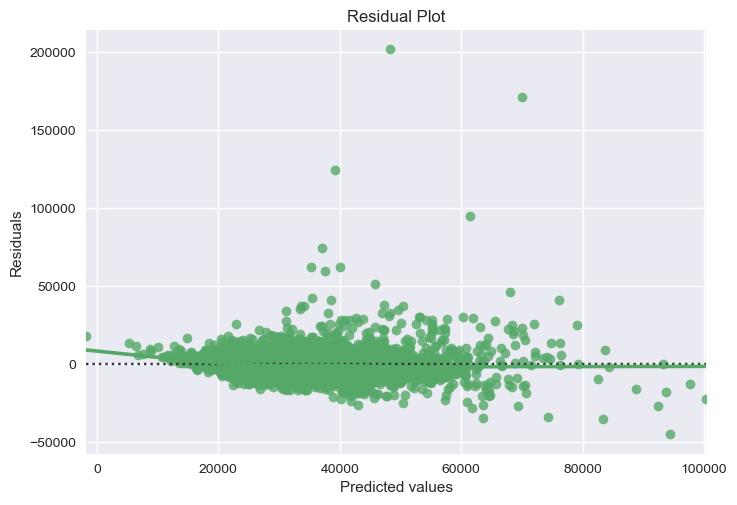

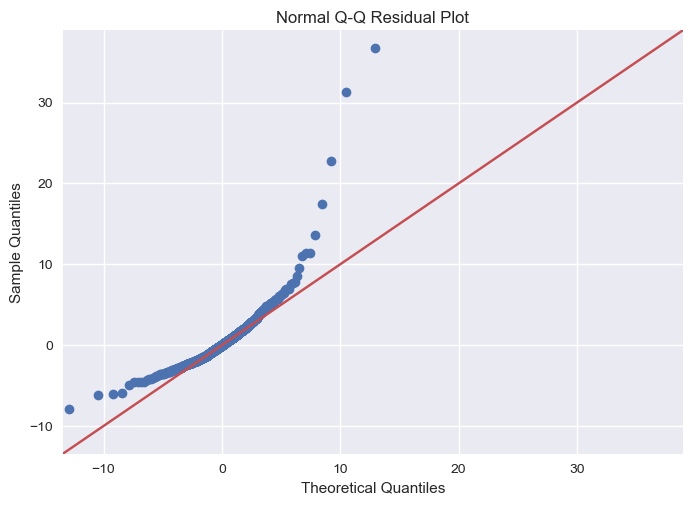

In [17]:
residuals = y_test[TARGET_VARIABLE] - y_pred
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

sm.qqplot(residuals, stats.t, fit=True, line='45')
plt.title("Normal Q-Q Residual Plot")
plt.show()

**Insight:**  
The residual plot has a funnel shape which usually indicates Heteroscedasticity.  
Heteroscedasticity in regression analysis refers to the situation where the variability of the errors (residuals) is not constant across all levels of the independent variable(s). It can lead to biased and inefficient estimates of the regression coefficients, and can also affect the accuracy of hypothesis tests and confidence intervals.

The 2nd figure from above is a Q-Q plot assessing data skew and model fit. This chart displays the standardized residuals on the y-axis and the theoretical quantiles on the x-axis. Data that aligns closely to the dotted line indicates a normal distribution. However, we can see that some points skew drastically from the line so we can actually consider adjusting our model by adding or removing other independent variables in the regression model.

But first, we tried to improve Heteroscedasticity by taking Log of the responding variable before re-running the linear regression as below:

#### 7. Run linear regression with log(Responding Variable) . Check R2, MSE, Residual Plot, Q-Q Plot

In [18]:
# LR with Log(Responding Variable)
# Apply log to y_train and y_test
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Fit the model with log transformed y_train
est = sm.OLS(y_train_log, X_train_transformed).fit()
print("LR with Log(Responding Variable):")
# Print the summary of the model
display(est.summary())

# Predict with log transformed y_test
y_pred_log = est.predict(X_test_transformed)

# Convert back to original scale
y_pred = np.exp(y_pred_log)
y_test_orig = np.exp(y_test_log)

# Calculate the R-squared and MSE
r_squared = r2_score(y_test_orig, y_pred)
mse = mean_squared_error(y_test_orig, y_pred)
print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

LR with Log(Responding Variable):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     864.2
Date:                Tue, 11 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:56:27   Log-Likelihood:                 741.53
No. Observations:               14087   AIC:                            -1423.
Df Residuals:                   14057   BIC:                            -1196.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      10.3990      0.002   5370.789      0.000      10.395      10.403
SAT_AVG                     0.0386      0.005      7.143      0.000       0.028       0.049
TUITIONFEE_IN               0.0194      0.009      2.112      0.035       0.001       0.037
TUITIONFEE_OUT             -0.0413      0.007     -6.080      0.000      -0.055      -0.028
AVGFACSAL                   0.0679      0.003     23.855      0.000       0.062       0.073
ADM_RATE                   -0.0054      0.002     -2.540      0.011      -0.010      -0.001
NUMBRANCH                   0.0475      0.002     20.146      0.000       0.043       0.052
TUITFTE                     0.0352      0.002     14.451      0.000       0.030       0.040
INEXPFTE                    0.0423      0.002     18.674      0.000       0.038       0.047
PRGMOFR                     0.0033      0.002      1.523      0.128      -0.001       0.007
COSTT4_A                    0.0054      0.007      0.721      0.471      -0.009       0.020
COSTT4_P                    0.0452      0.002     21.413      0.000       0.041       0.049
UGDS                        0.0267      0.002     11.029      0.000       0.022       0.031
UGDS_MEN                    0.0622      0.015      4.288      0.000       0.034       0.091
UGDS_WOMEN                  0.0004      0.014      0.026      0.979      -0.028       0.029
PFTFAC                     -0.0110      0.002     -5.121      0.000      -0.015      -0.007
PCTPELL                    -0.0485      0.003    -13.929      0.000      -0.055      -0.042
FTFTPCTFLOAN                0.0715      0.003     26.270      0.000       0.066       0.077
FTFTPCTPELL                -0.0482      0.004    -13.283      0.000      -0.055      -0.041
DEBT_MDN                    0.0603      0.004     16.213      0.000       0.053       0.068
RET_FT4                    -0.0268      0.002    -11.553      0.000      -0.031      -0.022
C200_L4                     0.0010      0.002      0.408      0.683      -0.004       0.006
LO_INC_COMP_ORIG_YR2_RT    -0.0069      0.003     -2.273      0.023      -0.013      -0.001
HI_INC_COMP_ORIG_YR2_RT    -0.0055      0.003     -2.124      0.034      -0.011      -0.000
MD_FAMINC                   0.0728      0.004     20.687      0.000       0.066       0.080
WDRAW_DEBT_MDN              0.0245      0.003      8.039      0.000       0.019       0.031
ACTCMMID                   -0.0260      0.005     -4.844      0.000      -0.037      -0.015
DEP_STAT_PCT_IND            0.0789      0.003     25.336      0.000       0.073       0.085
CONTROL_1                   0.0504      0.002     20.724      0.000       0.046       0.055
CONTROL_2                   0.0274      0.002     13.093      0.000       0.023       0.031
CONTROL_3                  -0.0721      0.002  

R-squared: 0.53
Mean squared error: 104561156.24
Root Mean squared error: 10225.51


**Insight**: 
The R-squared, MSE, and RMSE worsened compared to the first Multiple Linear Regression.

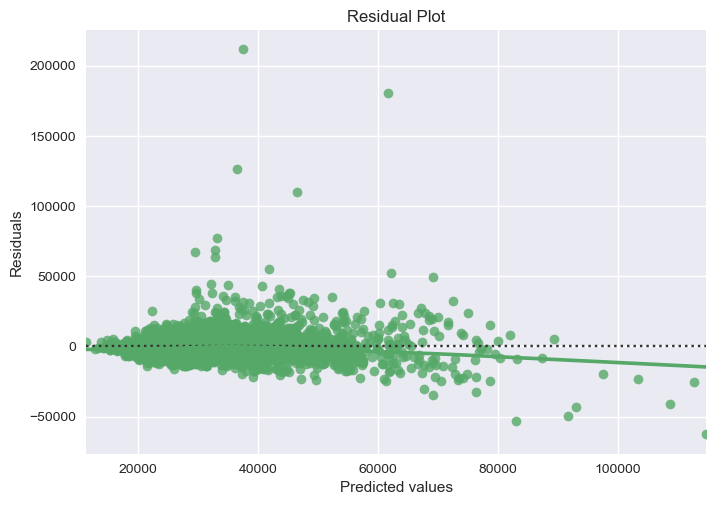

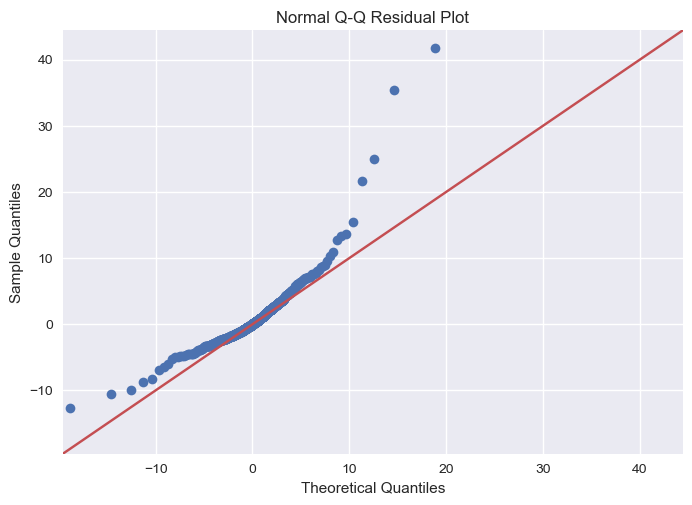

In [19]:
residuals = y_test_orig[TARGET_VARIABLE] - y_pred
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

sm.qqplot(residuals, stats.t, fit=True, line='45')
plt.title("Normal Q-Q Residual Plot")
plt.show()

**Insight**:
We could see from the Residual Plot above that Heteroscedasticity did not improve by much and that some points are still skewed drastically from the line in the Normal Q-Q Residual Plot. Therefore, taking log of the dependent variable is not a viable solution so we moved on to adjusting our model by adding or removing other independent variables in the next part.

#### 8. Improve the model
From the `est.summary()` we observe that some independent variables are not significant.  
We can drop those insignificant variables based on P-value.

In [20]:
drop_insignificant_features = ['TUITIONFEE_IN', 'ADM_RATE', 'PRGMOFR', 'COSTT4_A', 'UGDS_WOMEN', 'C200_L4', 'LO_INC_COMP_ORIG_YR2_RT']
X_train_transformed_copy = X_train_transformed.copy()
X_train_transformed_copy = X_train_transformed_copy.drop(columns=drop_insignificant_features)

X_test_transformed_copy = X_test_transformed.copy()
X_test_transformed_copy = X_test_transformed_copy.drop(columns=drop_insignificant_features)

Based on our trends drawn earlier on step 3, we observe that some variables don't have any trend (neither going up or down).  
We can try to drop them as well.

In [21]:
drop_constant_trend_features = ['NUMBRANCH', 'FTFTPCTFLOAN']
X_train_transformed_copy = X_train_transformed_copy.drop(columns=drop_constant_trend_features)
X_test_transformed_copy = X_test_transformed_copy.drop(columns=drop_constant_trend_features)

To further improve the model, we want to check multicolinearity between independent variables.

In [22]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(X_train_transformed_copy.corr())

,const,SAT_AVG,TUITIONFEE_OUT,AVGFACSAL,TUITFTE,INEXPFTE,COSTT4_P,UGDS,UGDS_MEN,PFTFAC,PCTPELL,FTFTPCTPELL,DEBT_MDN,RET_FT4,HI_INC_COMP_ORIG_YR2_RT,MD_FAMINC,WDRAW_DEBT_MDN,ACTCMMID,DEP_STAT_PCT_IND,CONTROL_1,CONTROL_2,CONTROL_3
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAT_AVG,NaN,1.000000,3.709113e-01,0.390519,0.182050,0.265102,5.659139e-05,0.162279,0.052971,0.065334,-0.229196,-0.260831,0.124733,0.350496,-0.038052,0.129339,-0.002858,9.246605e-01,0.030980,-0.050853,0.058171,-0.002996
TUITIONFEE_OUT,NaN,0.370911,1.000000e+00,0.476885,0.444282,0.297437,-2.970857e-19,0.007325,0.039477,0.193139,-0.301419,-0.445329,0.639228,0.368403,-0.145874,0.484651,0.355079,3.682083e-01,-0.270561,-0.373964,0.497535,-0.083654
AVGFACSAL,NaN,0.390519,4.768850e-01,1.000000,0.139451,0.364449,-5.094364e-02,0.355288,0.094017,0.182600,-0.480667,-0.487081,0.265210,0.384805,-0.290881,0.363822,0.208299,3.823852e-01,-0.311199,0.216917,0.141080,-0.331068
TUITFTE,NaN,0.182050,4.442821e-01,0.139451,1.000000,0.307827,1.411844e-01,-0.088804,0.025827,0.011586,-0.028280,-0.136026,0.365527,0.102249,0.031081,0.203573,0.236872,1.869842e-01,-0.031333,-0.399240,0.280541,0.132101
INEXPFTE,NaN,0.265102,2.974374e-01,0.364449,0.307827,1.000000,-6.184860e-03,0.063096,0.046678,0.157867,-0.252085,-0.244626,0.189745,0.198923,-0.089513,0.207003,0.145546,2.646265e-01,-0.154859,0.066387,0.182172,-0.224116
COSTT4_P,NaN,0.000057,-2.970857e-19,-0.050944,0.141184,-0.006185,1.000000e+00,0.004829,0.011137,-0.014759,0.050030,0.000389,0.012953,-0.001861,0.205255,0.028840,-0.047375,-8.575929e-20,-0.000045,-0.115789,0.001824,0.108580
UGDS,NaN,0.162279,7.325097e-03,0.355288,-0.088804,0.063096,4.828651e-03,1.000000,0.172686,0.050123,-0.290203,-0.282834,0.002268,0.161198,-0.304348,0.145699,0.081100,1.528314e-01,-0.215427,0.393589,-0.082011,-0.302113
UGDS_MEN,NaN,0.052971,3.947723e-02,0.094017,0.025827,0.046678,1.113705e-02,0.172686,1.000000,0.046391,-0.239137,-0.249767,0.143800,0.052927,-0.195358,0.175060,0.159062,4.915096e-02,-0.194003,0.208622,0.120945,-0.305386
PFTFAC,NaN,0.065334,1.931387e-01,0.182600,0.011586,0.157867,-1.475877e-02,0.050123,0.046391,1.000000,-0.183900,-0.220126,0.154533,0.210709,-0.094283,0.242847,0.094506,6.065566e-02,-0.276102,0.082290,0.185357,-0.242064


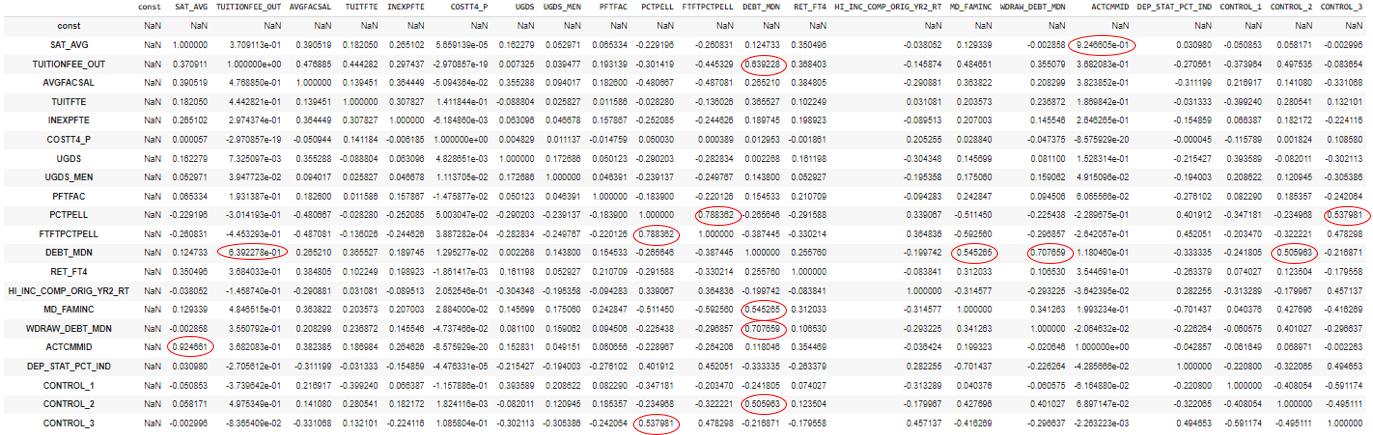

From the correlation table above, we could see that there are several moderately correlated indepent variables as circled in red. Therefore, we will remove 'DEBT_MDN', 'PCTPELL', and 'ACTCMMID' and re-run the LR.

In [23]:
X_train_transformed_copy = X_train_transformed_copy.drop(columns= ['DEBT_MDN', 'PCTPELL', 'ACTCMMID'])
X_test_transformed_copy = X_test_transformed_copy.drop(columns= ['DEBT_MDN', 'PCTPELL', 'ACTCMMID'])

In [24]:
est = sm.OLS(y_train, X_train_transformed_copy).fit()

display(est.summary())

y_pred = est.predict(X_test_transformed_copy)

r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     853.3
Date:                Tue, 11 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:57:16   Log-Likelihood:            -1.5080e+05
No. Observations:               14087   AIC:                         3.016e+05
Df Residuals:                   14069   BIC:                         3.018e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3.542e+04     90.910    389.564      0.000    3.52e+04    3.56e+04
SAT_AVG                   605.8907    110.484      5.484      0.000     389.327     822.454
TUITIONFEE_OUT            471.8778    153.549      3.073      0.002     170.901     772.855
AVGFACSAL                3468.0606    129.411     26.799      0.000    3214.398    3721.723
TUITFTE                  1944.4974    113.010     17.206      0.000    1722.983    2166.012
INEXPFTE                 2651.3593    105.640     25.098      0.000    2444.291    2858.427
COSTT4_P                 1456.7187     95.023     15.330      0.000    1270.462    1642.976
UGDS                      662.0879    107.347      6.168      0.000     451.673     872.503
UGDS_MEN                 2088.3221     97.829     21.347      0.000    1896.564    2280.080
PFTFAC                   -349.0620     97.368     -3.585      0.000    -539.916    -158.208
FTFTPCTPELL             -1625.0684    131.555    -12.353      0.000   -1882.934   -1367.203
RET_FT4                  -793.2407    106.765     -7.430      0.000   -1002.515    -583.966
HI_INC_COMP_ORIG_YR2_RT  -381.7706    111.016     -3.439      0.001    -599.377    -164.165
MD_FAMINC                2958.9986    152.762     19.370      0.000    2659.565    3258.432
WDRAW_DEBT_MDN           2113.7461    107.246     19.709      0.000    1903.529    2323.963
DEP_STAT_PCT_IND         3333.5164    139.847     23.837      0.000    3059.397    3607.635
CONTROL_1                 608.0939     90.482      6.721      0.000     430.737     785.451
CONTROL_2                1376.7627     82.827     16.622      0.000    1214.411    1539.114
CONTROL_3               -1794.9901     82.275    -21.817      0.000   -1956.261   -1633.720
==============================================================================
Omnibus:                    14824.513   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2668600.277
Skew:                           4.930   Prob(JB):                         0.00
Kurtosis:                      69.703   Cond. No.                     9.26e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.79e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

R-squared: 0.55
Mean squared error: 100239703.03
Root Mean squared error: 10011.98


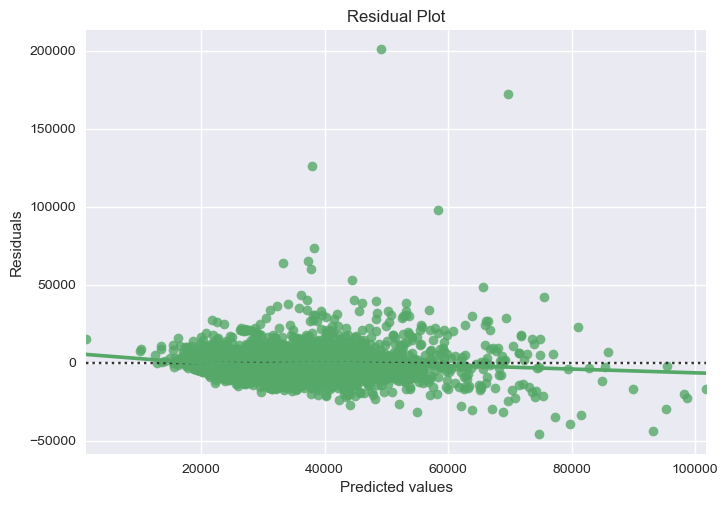

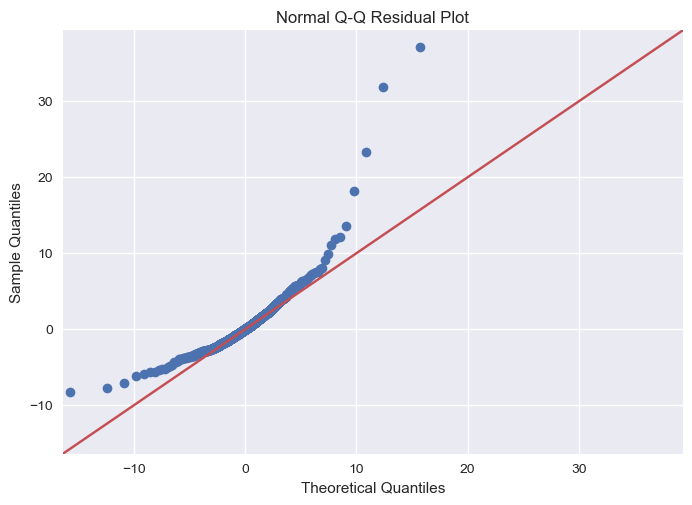

In [25]:
residuals = y_test[TARGET_VARIABLE] - y_pred
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

sm.qqplot(residuals, stats.t, fit=True, line='45')
plt.title("Normal Q-Q Residual Plot")
plt.show()

**Insight:**  
Our attempt of improving the model does not  show any improvement from the first MLR R-squared, MSE, and RMSE. 

Here we see that the remaining features can explain almost 50% of the target variable with the linearity assumption.

In the next part, we will attempt to fit a multiple polynomial regression model on the data.

#### 9. Multiple Polynomial Regression (degree = 2)

In [26]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2) 
X_train_poly = poly.fit_transform(X_train_transformed_copy)
X_test_poly= poly.transform(X_test_transformed_copy)

est = sm.OLS(y_train, X_train_poly).fit()

display(est.summary())

y_pred = est.predict(X_test_poly)

r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     154.8
Date:                Tue, 11 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:57:33   Log-Likelihood:            -1.4842e+05
No. Observations:               14087   AIC:                         2.972e+05
Df Residuals:                   13920   BIC:                         2.984e+05
Df Model:                         166                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5589.2877     36.939    151.313      0.000    5516.883    5661.692
x1          5589.2877     36.939    151.313      0.000    5516.883    5661.692
x2           552.7045    231.986      2.382      0.017      97.980    1007.429
x3            26.3212    117.208      0.225      0.822    -203.421     256.064
x4           941.8189     67.300     13.994      0.000     809.903    1073.735
x5          2462.0540    110.346     22.312      0.000    2245.762    2678.346
x6          1705.6878    130.077     13.113      0.000    1450.719    1960.657
x7           718.8361    165.018      4.356      0.000     395.378    1042.294
x8           792.0737    134.552      5.887      0.000     528.333    1055.814
x9           881.6910     80.473     10.956      0.000     723.954    1039.428
x10         -303.0537     58.094     -5.217      0.000    -416.926    -189.182
x11         -432.5613     71.943     -6.013      0.000    -573.580    -291.543
x12          278.3495     88.473      3.146      0.002     104.931     451.768
x13         -397.1546     75.510     -5.260      0.000    -545.164    -249.146
x14         2354.5971    105.056     22.413      0.000    2148.674    2560.520
x15          758.8812     61.967     12.246      0.000     637.417     880.345
x16         1335.0365     73.043     18.278      0.000    1191.863    1478.210
x17          451.6417     45.683      9.887      0.000     362.098     541.186
x18         -438.9883     32.939    -13.327      0.000    -503.552    -374.424
x19          -41.9913     47.089     -0.892      0.373    -134.292      50.309
x20         5589.2877     36.939    151.313      0.000    5516.883    5661.692
x21          552.7045    231.986      2.382      0.017      97.980    1007.429
x22           26.3212    117.208      0.225      0.822    -203.421     256.064
x23          941.8189     67.300     13.994      0.000     809.903    1073.735
x24         2462.0540    110.346     22.312      0.000    2245.762    2678.346
x25         1705.6878    130.077     13.113      0.000    1450.719    1960.657
x26          718.8361    165.018      4.356      0.000     395.378    1042.294
x27          792.0737    134.552      5.887      0.000     528.333    1055.814
x28          881.6910     80.473     10.956      0.000     723.954    1039.428
x29         -303.0537     58.094     -5.217      0.000    -416.926    -189.182
x30         -432.5613     71.943     -6.013      0.000    -573.580    -291.543
x31          278.3495     88.473      3.146      0.002     104.931     451.768
x32         -397.1546     75.510     -5.260      0.000    -545.164    -249.146
x33         2354.5971    105.056     22.413      0.000    2148.674    2560.520
x34          758.8812     61.967     12.246      0.000     637.417     880.345
x35         1335.0365     73.043     18.278      0.000    1191.863    1478.210
x3

R-squared: 0.65
Mean squared error: 77882945.54
Root Mean squared error: 8825.13


#### 10. Multiple Polynomial Regression (degree = 3)

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3) 
X_train_poly = poly.fit_transform(X_train_transformed_copy)
X_test_poly= poly.transform(X_test_transformed_copy)

est = sm.OLS(y_train, X_train_poly).fit()

display(est.summary())

y_pred = est.predict(X_test_poly)

r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     49.89
Date:                Tue, 11 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:57:45   Log-Likelihood:            -1.4441e+05
No. Observations:               14087   AIC:                         2.909e+05
Df Residuals:                   13034   BIC:                         2.989e+05
Df Model:                        1052                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2785.1772     27.014    103.100      0.000    2732.225    2838.129
x1          2785.1772     27.014    103.100      0.000    2732.225    2838.129
x2          6629.0280   5407.752      1.226      0.220   -3970.956    1.72e+04
x3          -246.0517    107.435     -2.290      0.022    -456.641     -35.463
x4           196.1956     69.786      2.811      0.005      59.405     332.986
x5          1024.1990     95.580     10.716      0.000     836.848    1211.550
x6           588.6332    131.796      4.466      0.000     330.293     846.973
x7           326.0517    197.237      1.653      0.098     -60.561     712.664
x8           783.3980    120.080      6.524      0.000     548.024    1018.772
x9            64.9937     67.263      0.966      0.334     -66.851     196.838
x10            3.3274     68.459      0.049      0.961    -130.863     137.518
x11         -191.0841     69.069     -2.767      0.006    -326.470     -55.698
x12         -114.2248     76.183     -1.499      0.134    -263.555      35.106
x13           17.6786     59.374      0.298      0.766     -98.703     134.061
x14          676.0796     90.085      7.505      0.000     499.499     852.660
x15          321.9423     42.672      7.545      0.000     238.300     405.585
x16          186.2230     70.075      2.657      0.008      48.866     323.580
x17           18.0745     27.492      0.657      0.511     -35.814      71.964
x18         -549.4853     19.532    -28.133      0.000    -587.770    -511.200
x19          468.2369     31.904     14.676      0.000     405.700     530.774
x20         2785.1772     27.014    103.100      0.000    2732.225    2838.129
x21         6629.0280   5407.752      1.226      0.220   -3970.956    1.72e+04
x22         -246.0517    107.435     -2.290      0.022    -456.641     -35.463
x23          196.1956     69.786      2.811      0.005      59.405     332.986
x24         1024.1990     95.580     10.716      0.000     836.848    1211.550
x25          588.6332    131.796      4.466      0.000     330.293     846.973
x26          326.0517    197.237      1.653      0.098     -60.561     712.664
x27          783.3980    120.080      6.524      0.000     548.024    1018.772
x28           64.9937     67.263      0.966      0.334     -66.851     196.838
x29            3.3274     68.459      0.049      0.961    -130.863     137.518
x30         -191.0841     69.069     -2.767      0.006    -326.470     -55.698
x31         -114.2248     76.183     -1.499      0.134    -263.555      35.106
x32           17.6786     59.374      0.298      0.766     -98.703     134.061
x33          676.0796     90.085      7.505      0.000     499.499     852.660
x34          321.9423     42.672      7.545      0.000     238.300     405.585
x35          186.2230     70.075      2.657      0.008      48.866     323.580
x3

R-squared: 0.58
Mean squared error: 94067277.97
Root Mean squared error: 9698.83


We can see that the Multiple Polynomial Regressions of degrees 2 yielded a clear improvement in R-squared, MSE, and RMSE from the first Multiple Linear Regression. However, this is still an unsatisfactory result.

We will move on to experiment on alternative models as below.

## Creating Random Forest Regressor

In [6]:
X_train_transformed = X_train_transformed.drop(columns=['const'])
X_test_transformed = X_test_transformed.drop(columns=['const'])

In [7]:
# create a RandomForestRegressor object
rf = RandomForestRegressor(n_estimators=35, max_depth=45, random_state=42)
# random_state=42
# fit the model on the training data
rf.fit(X_train_transformed, y_train.to_numpy().ravel())

# predict using the test data
y_pred = rf.predict(X_test_transformed)

# calculate performance metrics
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

R-squared: 0.82
Mean squared error: 41420934.16
Root Mean squared error: 6435.91


Performing grid search to find the best hyperparameters for our RandomForestRegressor:

In [65]:
from sklearn.model_selection import GridSearchCV

# define the random forest model
rf = RandomForestRegressor()

# define the hyperparameter grid to search over
param_grid = {
    'n_estimators' : [40, 50, 60, 70], 
    'max_features': ['int', 'float', 'sqrt','log2', None, 1.0],
    'max_depth': [40, 50, 60, 70],
    'min_samples_split': [1, 2],
    'min_samples_leaf': [1, 2]
}

# perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5)

# fit the grid search to the data
grid_search.fit(X_train_transformed, y_train.to_numpy().ravel())

# print the best hyperparameters and their corresponding mean test score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean test score: ", grid_search.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1280 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils

Best hyperparameters:  {'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
Best mean test score:  0.8365767345032543


In [29]:
from sklearn.model_selection import GridSearchCV

# define the random forest model
rf = RandomForestRegressor()

# define the hyperparameter grid to search over
param_grid = {
    'n_estimators' : [50, 60, 70, 80], 
    'max_features': ['int', 'float', 'sqrt','log2', None, 1.0],
    'max_depth': [50, 60, 70, 80],
    'min_samples_split': [1, 2],
    'min_samples_leaf': [1, 2]
}

# perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5)

# fit the grid search to the data
grid_search.fit(X_train_transformed, y_train.to_numpy().ravel())

# print the best hyperparameters and their corresponding mean test score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean test score: ", grid_search.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1280 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils

Best hyperparameters:  {'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
Best mean test score:  0.83658102989931


In [8]:
# create a RandomForestRegressor object
rf = RandomForestRegressor(n_estimators=40, max_depth=40, max_features='log2', min_samples_leaf=1, min_samples_split=2)
# random_state=42
# fit the model on the training data
rf.fit(X_train_transformed, y_train.to_numpy().ravel())

# predict using the test data
y_pred = rf.predict(X_test_transformed)

# calculate performance metrics
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

R-squared: 0.84
Mean squared error: 34862157.23
Root Mean squared error: 5904.42


### Plotting Feature Importances of the RandomForestRegressor

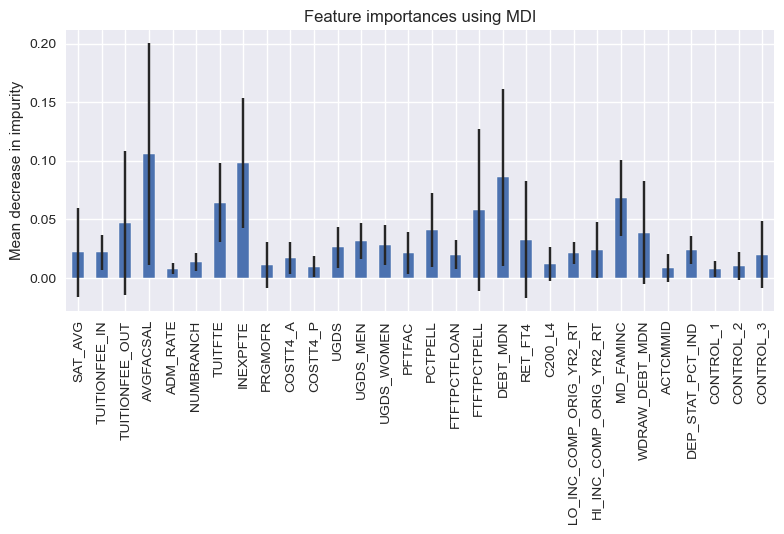

In [9]:
feature_names = X.columns

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

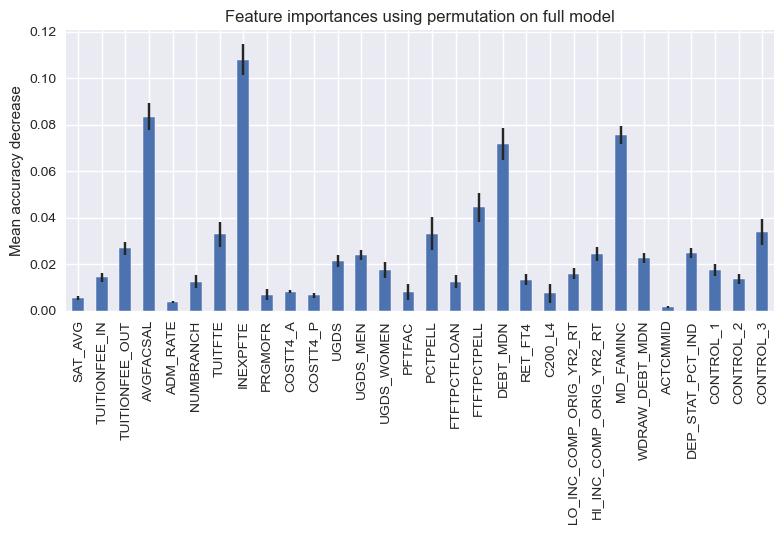

In [10]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test_transformed, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

**Insight:**  
Random Forest Regressor is an ensemble method that combines multiple decision trees to make a prediction. Each tree in the forest is trained on a different subset of the data and features, making it less prone to overfitting than a single decision tree. Additionally, Random Forest Regressor can capture **complex non-linear relationships between the features and target variable, which might be difficult for a simple linear regression model**.

On the other hand, OLS assumes a linear relationship between the features and target variable, and might not perform well when the relationship is non-linear or there are interactions between features. Therefore, if the relationship between the features and target variable is non-linear or there are interactions between features, Random Forest Regressor can perform better than OLS, resulting in a higher r-square value.  

Let's also create a simple Neural Network Regression model to see whether it can capture the non-linear relationship.

### Creating XGBRegressor

In [30]:
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.2/70.9 MB 4.1 MB/s eta 0:00:18
     ---------------------------------------- 0.5/70.9 MB 5.9 MB/s eta 0:00:12
     ---------------------------------------- 0.7/70.9 MB 5.8 MB/s eta 0:00:13
      --------------------------------------- 1.3/70.9 MB 6.7 MB/s eta 0:00:11
     - -------------------------------------- 1.8/70.9 MB 7.6 MB/s eta 0:00:10
     - -------------------------------------- 2.4/70.9 MB 8.3 MB/s eta 0:00:09
     - -------------------------------------- 2.7/70.9 MB 8.2 MB/s eta 0:00:09
     - -------------------------------------- 3.2/70.9 MB 8.0 MB/s eta 0:00:09
     - -------------------------------------- 3.4/70.9 MB 8.4 MB/s eta 0:00:09
     -- ------------------------------------- 3.7/70.9 MB 7.9 MB/s eta 0:00:09
     -- ------------------------------------- 4.2/70.9 MB 8.1 MB/s eta 0:00:09
     -- ------------------------------------- 4.6/70.9 MB 8

In [32]:
# create a XGB Regressor object
xgb_reg = xgb.XGBRegressor(random_state=42)
# random_state=42
# fit the model on the training data
xgb_reg.fit(X_train_transformed, y_train.to_numpy().ravel())

# predict using the test data
xgb_y_pred = xgb_reg.predict(X_test_transformed)

# calculate performance metrics
r_squared = r2_score(y_test, xgb_y_pred)
mse = mean_squared_error(y_test, xgb_y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

#Output:
# R-squared: 0.82
# Mean squared error: 39617392.79
# Root Mean squared error: 6294.23

R-squared: 0.82
Mean squared error: 39617392.79
Root Mean squared error: 6294.23


### Default Params Setup

In [33]:
# define the xgb regressor model
xgb_reg = xgb.XGBRegressor(random_state=42)

# define the hyperparameter grid to search over
xgb_param_grid = {
    'max_depth': [6, 50, 80, 100],
    'learning_rate' :[0.01,0.1,1],
    'colsample_bytree':[0.5,0.75,1],
    'subsample': [0.25,0.5,0.75,1]
}

# perform grid search using 5-fold cross-validation
xgb_grid_search = GridSearchCV(xgb_reg, xgb_param_grid, cv=5, scoring ='neg_root_mean_squared_error')

# fit the grid search to the data
xgb_grid_search.fit(X_train_transformed, y_train.to_numpy().ravel())

# print the best hyperparameters and their corresponding mean test score
print("Best hyperparameters: ", xgb_grid_search.best_params_)
print("Best mean test score: ", xgb_grid_search.best_score_)

#Output:
# Best hyperparameters:  {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 100, 'subsample': 0.75}
# Best mean test score:  -5964.558526835889

Best hyperparameters:  {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 100, 'subsample': 0.75}
Best mean test score:  -5964.558526835889


### 1st Optimization Run

In [34]:
# define the xgb regressor model
xgb_reg = xgb.XGBRegressor(random_state=42)

# define the hyperparameter grid to search over
xgb_param_grid = {
    'max_depth': [6, 50, 80, 100],
    'learning_rate' :[0.01,0.1,1],
    'colsample_bytree':[0.5,0.75,1],
    'subsample': [0.25,0.5,0.75,1]
}

# perform grid search using 5-fold cross-validation
xgb_grid_search = GridSearchCV(xgb_reg, xgb_param_grid, cv=5)

# fit the grid search to the data
xgb_grid_search.fit(X_train_transformed, y_train.to_numpy().ravel())

# print the best hyperparameters and their corresponding mean test score
print("Best hyperparameters: ", xgb_grid_search.best_params_)
print("Best mean test score: ", xgb_grid_search.best_score_)

#Output:
# Best hyperparameters:  {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 100, 'subsample': 0.75}
# Best mean test score:  0.8490247477405901


Best hyperparameters:  {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 100, 'subsample': 0.75}
Best mean test score:  0.8490247477405901


In [36]:
# create a XGB Regressor object
xgb_reg = xgb.XGBRegressor(n_estimators = 300, colsample_bytree = 0.75,learning_rate = 0.1,max_depth = 100,subsample=0.75,random_state=42)
# random_state=42
# fit the model on the training data
xgb_reg.fit(X_train_transformed, y_train.to_numpy().ravel())

# predict using the test data
xgb_y_pred = xgb_reg.predict(X_test_transformed)

# calculate performance metrics
r_squared = r2_score(y_test, xgb_y_pred)
mse = mean_squared_error(y_test, xgb_y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

#Output:
# R-squared: 0.85
# Mean squared error: 32851478.92
# Root Mean squared error: 5731.62

R-squared: 0.85
Mean squared error: 32851478.92
Root Mean squared error: 5731.62


### 2nd Optimization Run

In [37]:
# define the xgb regressor model
xgb_reg = xgb.XGBRegressor(random_state=42)

# define the hyperparameter grid to search over
xgb_param_grid = {
    'max_depth': [90, 100,120,140,160],
    'learning_rate' :[0.08,0.1,0.2,0.3],
    'colsample_bytree':[0.65,0.75,0.85],
    'subsample': [0.65,0.75,0.85]
}

# perform grid search using 5-fold cross-validation
xgb_grid_search = GridSearchCV(xgb_reg, xgb_param_grid, cv=5)

# fit the grid search to the data
xgb_grid_search.fit(X_train_transformed, y_train.to_numpy().ravel())

# print the best hyperparameters and their corresponding mean test score
print("Best hyperparameters: ", xgb_grid_search.best_params_)
print("Best mean test score: ", xgb_grid_search.best_score_)

#Output:
# Best hyperparameters:  {'colsample_bytree': 0.65, 'learning_rate': 0.08, 'max_depth': 90, 'subsample': 0.85}
# Best mean test score:  0.8541635693130532

Best hyperparameters:  {'colsample_bytree': 0.65, 'learning_rate': 0.08, 'max_depth': 90, 'subsample': 0.85}
Best mean test score:  0.8541635693130532


In [38]:
# create a XGB Regressor object
xgb_reg = xgb.XGBRegressor(n_estimators = 300, colsample_bytree = 0.65,learning_rate = 0.08,max_depth = 90,subsample=0.85,random_state=42)
# random_state=42
# fit the model on the training data
xgb_reg.fit(X_train_transformed, y_train.to_numpy().ravel())

# predict using the test data
xgb_y_pred = xgb_reg.predict(X_test_transformed)

# calculate performance metrics
r_squared = r2_score(y_test, xgb_y_pred)
mse = mean_squared_error(y_test, xgb_y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

R-squared: 0.86
Mean squared error: 30880708.90
Root Mean squared error: 5557.04


In [42]:
n_est = [50,100,150,200,250,300,350,400]
mse_list =[]
r_sq_list=[]
rmse_list=[]

for i in n_est:
    # create a XGB Regressor object
    xgb_reg = xgb.XGBRegressor(n_estimators = i, colsample_bytree = 0.65,learning_rate = 0.08,max_depth = 90,subsample=0.85,random_state=42)
    # random_state=42
    # fit the model on the training data
    xgb_reg.fit(X_train_transformed, y_train.to_numpy().ravel())

    # predict using the test data
    xgb_y_pred = xgb_reg.predict(X_test_transformed)

    # calculate performance metrics
    r_squared = r2_score(y_test, xgb_y_pred)
    mse = mean_squared_error(y_test, xgb_y_pred)
    rmse = np.sqrt(mse)
    
    mse_list.append(mse)
    r_sq_list.append(r_squared)
    rmse_list.append(rmse)



In [43]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

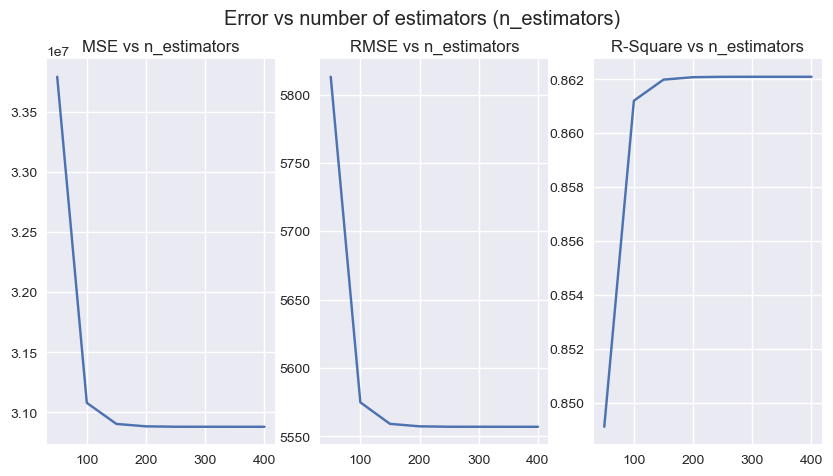

In [52]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(10,5))
fig.suptitle('Error vs number of estimators (n_estimators)')
ax1.plot(n_est, mse_list)
ax1.set_title('MSE vs n_estimators')

ax2.plot(n_est, rmse_list)
ax2.set_title('RMSE vs n_estimators')

ax3.plot(n_est, r_sq_list)
ax3.set_title('R-Square vs n_estimators')

plt.show

### Final XGB Regressor Model

Final n_estimator is chosen to be 200 as increasing the number of estimators only serve to yield negligible improvement to the model while vastly increasing the time taken for the model to run.

In [54]:
# create a XGB Regressor object
xgb_reg = xgb.XGBRegressor(n_estimators = 200, colsample_bytree = 0.65,learning_rate = 0.08,max_depth = 90,subsample=0.85,random_state=42)
# random_state=42
# fit the model on the training data
xgb_reg.fit(X_train_transformed, y_train.to_numpy().ravel())

# predict using the test data
xgb_y_pred = xgb_reg.predict(X_test_transformed)

# calculate performance metrics
r_squared = r2_score(y_test, xgb_y_pred)
mse = mean_squared_error(y_test, xgb_y_pred)

print(f"R-squared: {r_squared:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Root Mean squared error: {np.sqrt(mse):.2f}")

R-squared: 0.86
Mean squared error: 30884170.62
Root Mean squared error: 5557.35


### Feature Importance

In [55]:
from xgboost import plot_importance
from matplotlib import pyplot

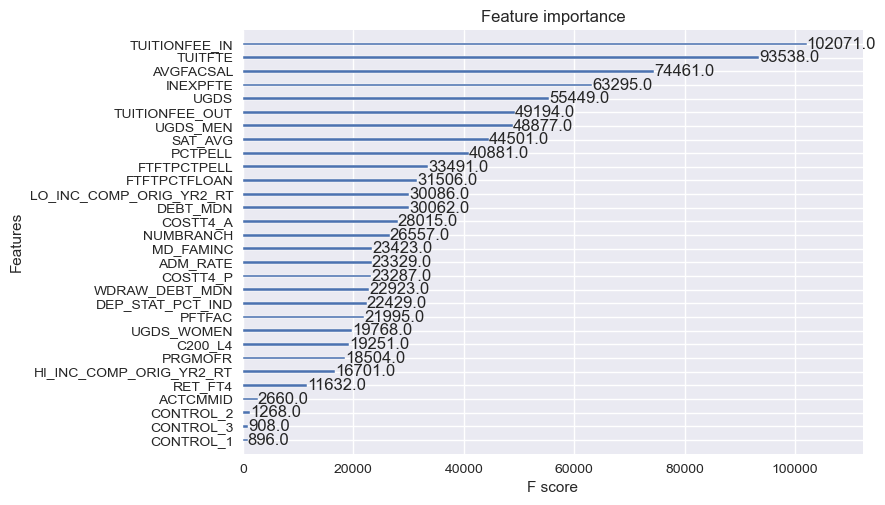

<Figure size 1000x600 with 0 Axes>

In [58]:
# create a XGB Regressor object
xgb_reg = xgb.XGBRegressor(n_estimators = 200, colsample_bytree = 0.65,learning_rate = 0.08,max_depth = 90,subsample=0.85,random_state=42)
# random_state=42
# fit the model on the training data
xgb_reg.fit(X_train_transformed, y_train.to_numpy().ravel())

#Feature Importance chart
plot_importance(xgb_reg)
pyplot.show()

## Create Neural Network Model

In [17]:
X_train_numpy, X_test_numpy, y_train_numpy, y_test_numpy = X_train_transformed.to_numpy(), X_test_transformed.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

X_train_tensor = torch.tensor(X_train_numpy, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numpy, dtype=torch.float32).reshape(-1,1)
X_test_tensor = torch.tensor(X_test_numpy, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numpy, dtype=torch.float32).reshape(-1, 1)
model = nn.Sequential(
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 80),
    nn.ReLU(),
    nn.Linear(80, 70),
    nn.ReLU(),
    nn.Linear(70, 60),
    nn.ReLU(),
    nn.Linear(60, 50),
    nn.ReLU(),
    nn.Linear(50, 27),
    nn.ReLU(),
    nn.Linear(27, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 600   # number of epochs to run
batch_size = 20  # size of each batch
batch_start = torch.arange(0, len(X_train_tensor), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
best_r2 = -np.inf
history_mse = []
history_r2 = []

# Early Stopping parameters
patience = 10
counter = 0
best_epoch = 0
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_tensor)
    mse = loss_fn(y_pred, y_test_tensor)
    mse = float(mse)
    history_mse.append(mse)
    r2 = torch_r2_score(y_pred, y_test_tensor).item()
    history_r2.append(r2)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}, best mse: {best_mse}")
            break
    if r2 > best_r2:
        best_r2 = r2


Epoch 105: 100%|██████████| 705/705 [00:05<00:00, 122.23batch/s, mse=5.57e+6]


Epoch 210: 100%|██████████| 705/705 [00:06<00:00, 114.25batch/s, mse=5.2e+6] 


Epoch 283: 100%|██████████| 705/705 [00:06<00:00, 116.49batch/s, mse=4.07e+6]


Early stopping at epoch 283, best mse: 44579200.0


R-Squared: 0.80


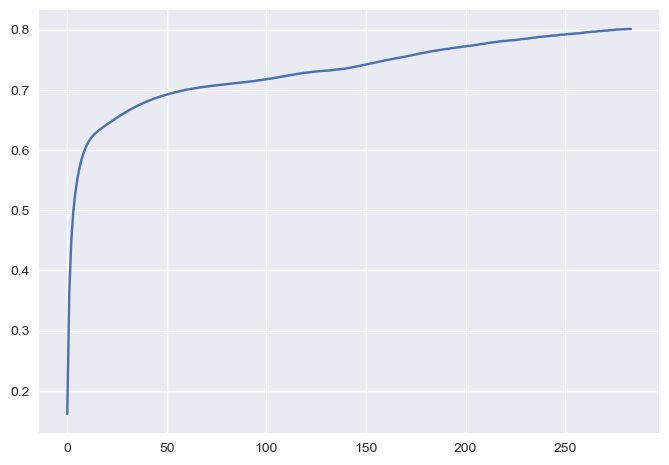

Mean squared error: 44579200.00


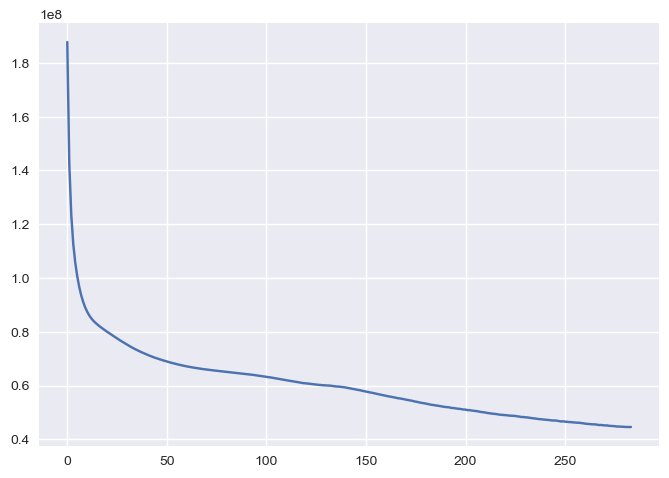

Root Mean squared error: 6676.77


In [18]:
# restore model and return best mse
model.load_state_dict(best_weights)
print(f"R-Squared: {best_r2:.2f}")
plt.plot(history_r2)
plt.show()

print(f"Mean squared error: {best_mse:.2f}")
plt.plot(history_mse)
plt.show()

print(f"Root Mean squared error: {np.sqrt(best_mse):.2f}")

### Feature Attibution

In [19]:
# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

ig = IntegratedGradients(model)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test_tensor, n_steps=50)
dl_attr_test = dl.attribute(X_test_tensor)
gs_attr_test = gs.attribute(X_test_tensor, X_train_tensor)
fa_attr_test = fa.attribute(X_test_tensor)

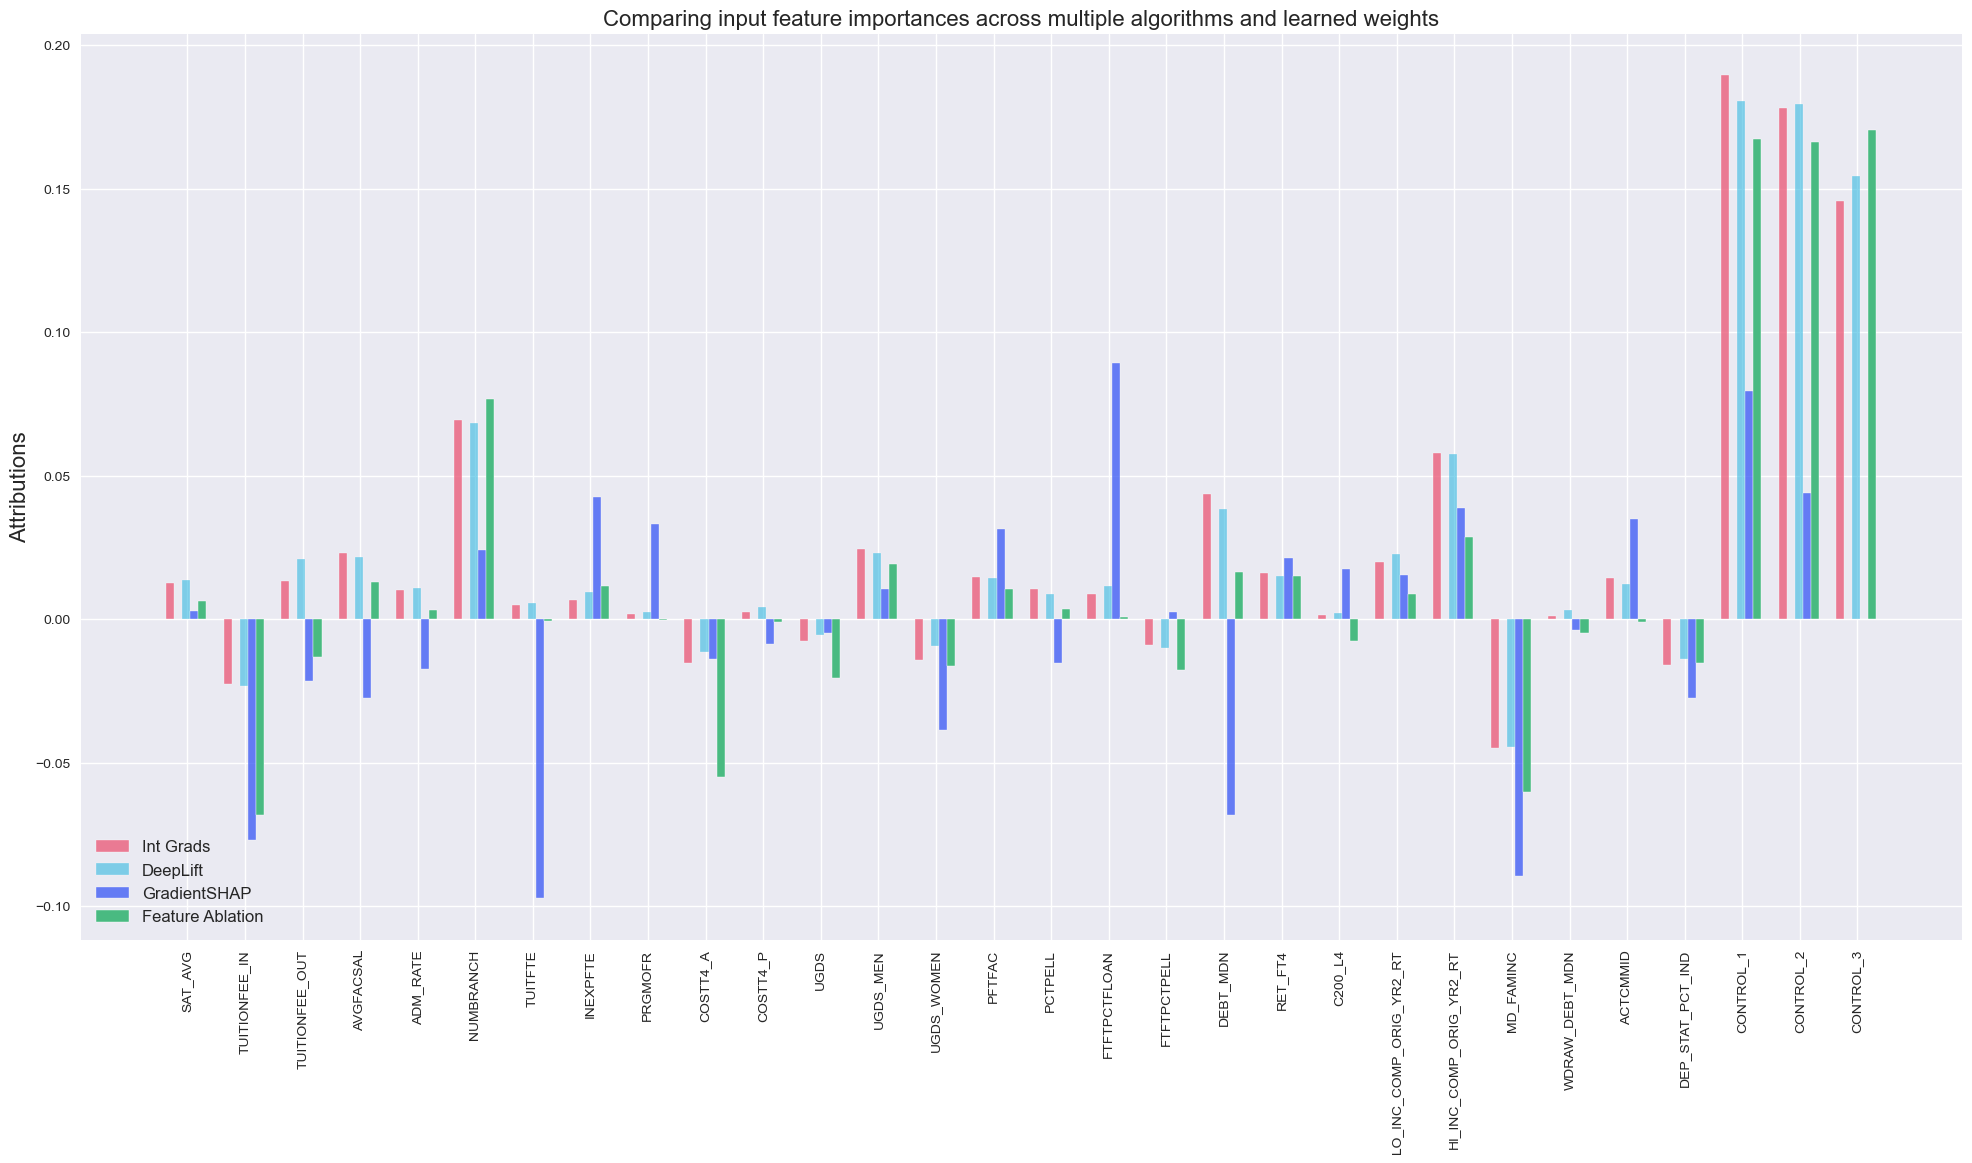

In [43]:
# prepare attributions for visualization
feature_names = list(X.columns)
x_axis_data = np.arange(X_test_tensor.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Int Grads','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.3)
ax.set_xticklabels(x_axis_data_labels, rotation=90)

plt.legend(legends, loc=3)
plt.show()

## Conclusion

We created three regression models. The first is OLS (Ordinary Linear Regression) model, the second is RFR (RandomForestRegressor) model and the third is NN (NeuralNetwork).  

We can observe that by using the same train and test data, our OLS model performs worse than the RFR and NN, based on the R<sup>2</sup> and MSE score.  

Based on our analysis, these are the reasons based on our understanding:
1. Even though we have selected many features to represents the school background, our OLS model turns out to not have a strong linear relationship with the target variable and must have a more complex relationship. This is shown by how much better the R<sup>2</sup> of RFR model is. RFR is known for its ability to capture non-linear relationships between the input features and target variable more effectively than OLS. This is because RFR constructs a series of decision trees to make predictions, and each tree can capture different patterns in the data. Neural Networks can also capture non-linear relationships, but their performance can depend on the choice of architecture and hyperparameters.
2. High-dimensional data: RFR can handle high-dimensional data with many input features, as it only considers a subset of the features at each split in the decision trees. This can help to avoid the curse of dimensionality and reduce overfitting. OLS and NN can also handle high-dimensional data, but they may be more prone to overfitting.
3. Outliers: RFR is robust to outliers and noisy data, as it uses an ensemble of decision trees to make predictions. This can help to reduce the impact of individual data points that may have large errors. OLS can be sensitive to outliers, as it tries to minimize the sum of squared errors, which can be dominated by outliers. NN can also be sensitive to outliers, depending on the activation function and loss function used.
4. Neural Networks require a large amount of data to learn complex relationships, and may not perform as well with smaller datasets. If you have a small dataset, Random Forest Regressor may outperform Neural Networks.
5. There are quite a big number of missing data on the features so we have to do data imputation which may or may not help with the prediction.

It is possible to build a model to perform salary estimation based on school/student background provided by the College Scorecard. We have shown that our selected features do not only have a linear relationship but also other complex relationships that are not able to be captured by OLS alone. This is confirmed by both RFR and NN models. Both RFR and NN gives higher R<sup>2</sup> and lower MSE. However, we suspect that due insufficient data, feature selection and also lack of experience on building optimal NN models, our NN model does not outperform RFR.  

Finally, whether or not the model is useful or not depends on our needs. Our best model, RFR, can capture the most relationship with the target variable. The MSE is `56578786.52` which means that our future predictions are off by around `7521.89`. It can be considered good or bad, depending on what we are trying to do. For example, our model can be used to give a student an idea of which earning groups they will be if they go to a school that has certain backgrounds (our features).

Several notes for future improvements:
1. Gain more in-depth understanding of the College Scorecard in order to perform more advanced data cleaning and data preprocessing procedures.
2. Replace missing datas with a real data. Which can be sourced from other 3rd parties. Not only filling missing data, a new features related to the school/institutions can also be obtained to make our model, especially NN, learns more.
3. Train the model using a more granular dataset (if it is available in the future) instead of using the aggregated dataset like  what's currently being provided by the College Scorecard. For example, it would be very helpful if a more granular down to each student are present. However, we understand that it can only be accessed by a body that has permit due to privacy concerns.
4. A more powerful hardware to train the model with the help of GPU would be very helpful so that we can do more iterations and more experiments with different features and hyperparameter tuning.
5. Gain more expertise on NN techniques.